In [2]:
print("Hellow World!")

Hellow World!


In [3]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os
import pandas as pd
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


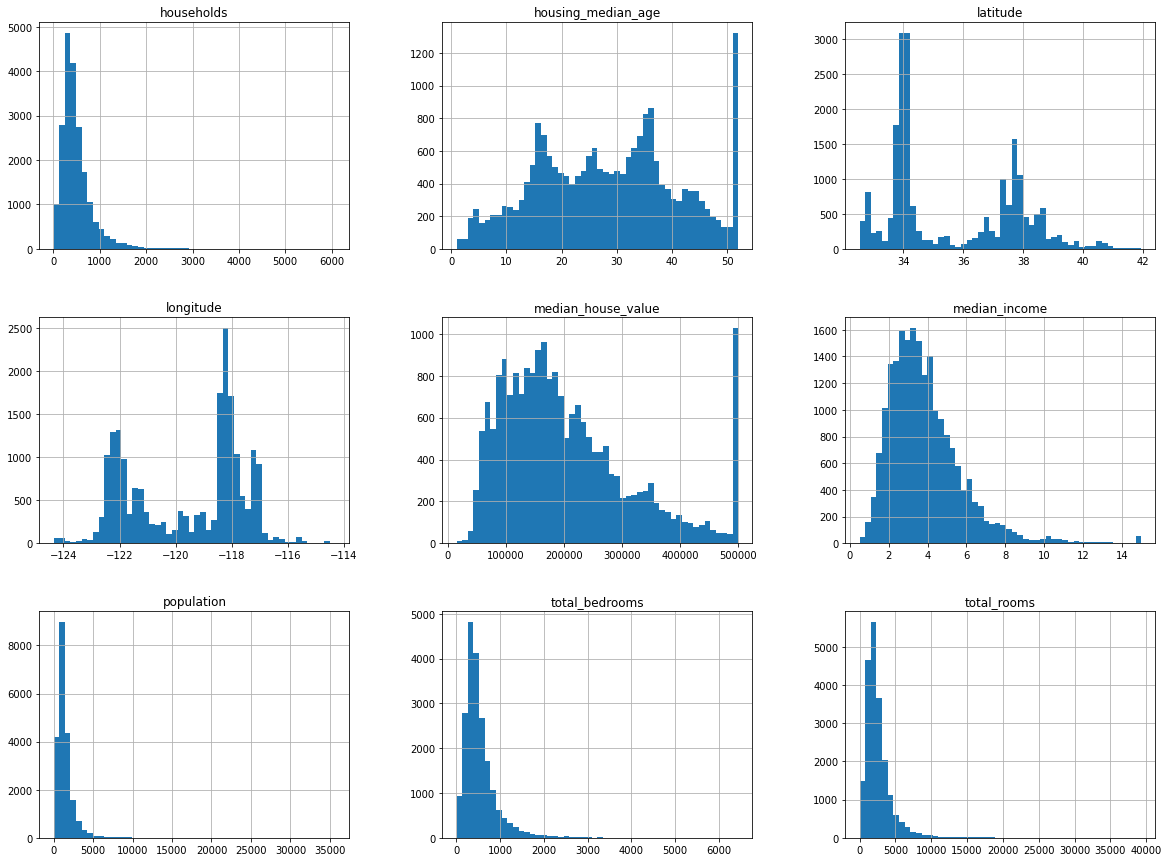

In [8]:
import matplotlib.pyplot as plt

housing.hist(bins = 50 , figsize=(20,15))
plt.show()



let us take a closer look at the *median_income hist* most of the data fall between 1.5 to 6 , so inorder to have the same ratios of split in trains and test set we use ***StratifiedShuffleSplit***

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"] , bins = [0. , 1.5 , 3 , 4.5 , 6. , np.inf] , labels=[1,2,3,4,5])

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1 , random_state =5 , test_size =  0.2)

for train_index , test_index in split.split(housing , housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set  = housing.loc[test_index]


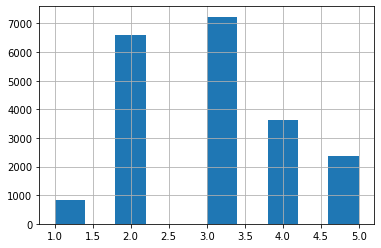

In [11]:
housing["income_cat"].hist()

Dropping the created *income_cat* column

In [12]:
for set_ in (strat_train_set , strat_test_set):
  set_.drop("income_cat" , inplace = True , axis= 1)

Copying data to so that there is no chance of harming the training data

In [13]:
housing = strat_train_set.copy()

We have *latitude* and *longitude* in the dataset lets visualize them with a scatterplot , this graph of california has more densities on Bay areas of San Diego and Los Angeles xD

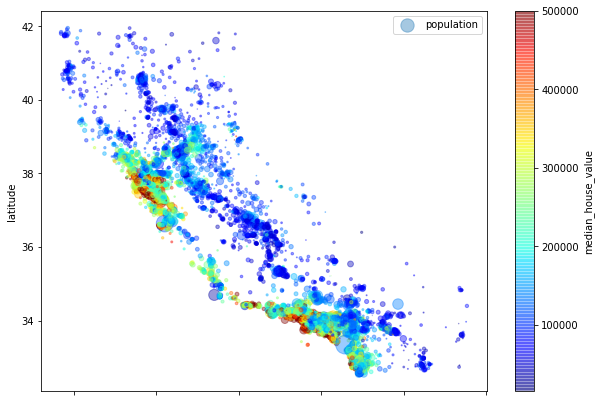

In [14]:
housing.plot(kind ="scatter" , x = "longitude" , y = "latitude" , alpha=0.4,
             figsize=(10,7) , s=housing["population"]/100  , label="population",
             c="median_house_value", cmap=plt.get_cmap("jet") , colorbar=True)
plt.legend()

In [15]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.686517
total_rooms           0.135338
housing_median_age    0.104154
households            0.066256
total_bedrooms        0.051036
population           -0.023767
longitude            -0.047873
latitude             -0.142519
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35ac9f6240>,
      dtype=object)

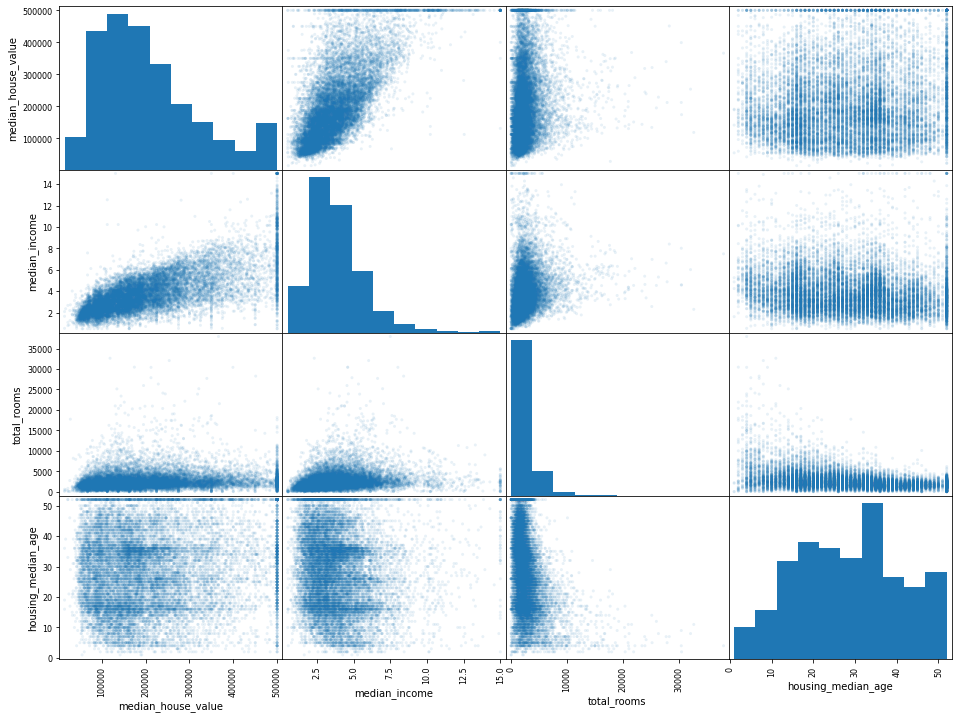

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value" , "median_income" , "total_rooms" , "housing_median_age"]

scatter_matrix(housing[attributes],figsize=(16,12),alpha = 0.1)

Lets take a closer look to *median_income vs medina_house_value*  

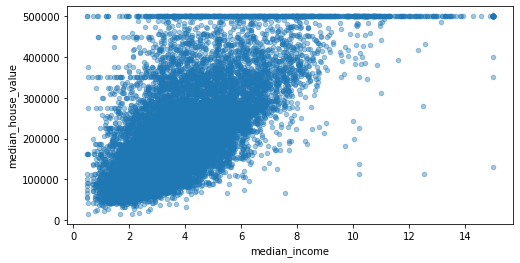

In [17]:
housing.plot(kind = "scatter" , x = "median_income" , y="median_house_value" , figsize = (8,4) , alpha=0.4)

Notice straight lines at 5000 , 3500 , 2800 , 1700 , these may effect our training , and so many histograms are tail heavy we need to do something about that tooo , turning them to log values may be helpful , lets see about it later

In [18]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Whoa the *room_per_household* definitely have an effect on the target value

In [19]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.686517
rooms_per_household         0.143933
total_rooms                 0.135338
housing_median_age          0.104154
households                  0.066256
total_bedrooms              0.051036
population_per_household   -0.021516
population                 -0.023767
longitude                  -0.047873
latitude                   -0.142519
bedrooms_per_room          -0.255313
Name: median_house_value, dtype: float64

Reverting back to the original data set , to perform data cleaning

*notice that **drop** creates a copy with out modifying the original data set*

In [20]:
housing = strat_train_set.drop("median_house_value" , axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

 **Data Cleaning**

We have the *total_bedrooms* attribute missing for some districts , we have three options.

**1.** Get rid of corresponding Districts
* *housing.dropna(subset=["total_bedrooms"])*

**2.** Get rid of whole attribute
* *housing.drop("total_bedrooms", axis=1)*

**3.** Set the values to some values (Mean , Median , etc)
* *median = housing["total_bedrooms"].median()*
* *housing["total_bedrooms"].fillna(median , inplace=True)*


**Imputer**

The easy way to do this is an Imputer let's see the implementation of a *SimpleImputer* , but first we have to remove the categorical columns from the input data

In [21]:
# removing the categorical columns
housing_num = housing.drop("ocean_proximity" , axis = 1)

In [22]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

# fit the imputer with housing values so that it can calculate the median of each attribute
imputer.fit(housing_num)
# the imputer returns a plain np.array 
X = imputer.transform(housing_num)
# converting the produced array to a DataFrame
housing_tr = pd.DataFrame(X , index = housing_num.index , columns = housing_num.columns)

**OrdinalEncoder**

To encode the categorical columns we use *OrdinalEncoder*

In [23]:
housing_cat = housing[["ocean_proximity"]].copy()

housing_cat.head(10)

,ocean_proximity
14585,NEAR OCEAN
4471,<1H OCEAN
10142,<1H OCEAN
7626,<1H OCEAN
4247,<1H OCEAN
2535,INLAND
13088,INLAND
14643,NEAR OCEAN
12887,INLAND
10110,<1H OCEAN


In [24]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

# we can use fit_transform instead of writing two individual steps , there will be a slight advantage in runtimes
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [25]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [26]:
housing_cat_encoded[:10]

array([[4.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.]])

uh ohhh ! , wait wait this column doesnt contains values like 
*bad,Average,Good,Excellent* which are relatable to each other to *OrdinalEncode* them , we have values which are not relatable to each other so we should *OneHotEncode* them Lets see the implementation of it.

In [27]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)


In [28]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

**Custom transformers**

*BaseEstimator,TransFormerMixin*

In [29]:
from sklearn.base import BaseEstimator,TransformerMixin

# idexes for various attributes
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator , TransformerMixin):
  # initialize the class , set True by default
  def __init__(self , add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room

  # fit function  
  def fit(self , X , y = None):
    return self #doing nothing

  # transform the input dataFrame
  def transform(self , X):
    rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
    population_per_household = X[:,population_ix] / X[:,households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
      return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
    else:
      return np.c_[X,rooms_per_household,population_per_household]

In [30]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

housing_extra_attribs = attr_adder.transform(housing.values)

In [31]:
housing_extra_attribs[:1,:]

array([[-117.19, 32.84, 30.0, 2492.0, 406.0, 1250.0, 431.0, 5.5277,
        'NEAR OCEAN', 5.781902552204176, 2.9002320185614847]],
      dtype=object)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline ([
                          ('imputer' , SimpleImputer(strategy="median")),
                          ('attribs_adder' , CombinedAttributesAdder()),
                          ('std_scaler' , StandardScaler())
])

In [33]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [34]:
housing_num_tr[:2,:]

array([[ 1.18833929, -1.30610549,  0.10823333, -0.06439516, -0.31009307,
        -0.15179245, -0.17598969,  0.86459325,  0.1288318 , -0.01710582,
        -0.76663983],
       [ 0.69921865, -0.72149457,  0.3456861 ,  0.12530666,  0.62871543,
         1.5553567 ,  0.77286957, -0.8573323 , -0.67659407,  0.08215547,
         0.90912582]])

**Pipeline cat and num columns**

we saw the numerical pipeline above , lets use both numerical and categorical columns ina single pipeline , we can make it possible by using the *ColumnTransformer*

In [35]:
from sklearn.compose import ColumnTransformer

num_attributes = list(housing_num)
cat_attributes = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ('num' , num_pipeline , num_attributes),
                                   ('cat' , OneHotEncoder() , cat_attributes)
])

In [36]:
housing_prepared = full_pipeline.fit_transform(housing)

In [37]:
housing_prepared[:1 , :]

array([[ 1.18833929, -1.30610549,  0.10823333, -0.06439516, -0.31009307,
        -0.15179245, -0.17598969,  0.86459325,  0.1288318 , -0.01710582,
        -0.76663983,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

**Training**



In [38]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

**Linear Regression**

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
print("predictions: " , lin_reg.predict(some_data_prepared))
print("labels: ", list(some_labels))

predictions:  [286277.81269355 134724.75198095 355476.28517664 191641.25372081
 360181.95254176]
labels:  [197100.0, 146600.0, 258200.0, 168600.0, 500001.0]


In [41]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_predictions , housing_labels)
lin_rmse = np.sqrt(lin_rmse)

print("lin_rmse: ",lin_rmse)

lin_rmse:  68651.87316060731


**Decision Tree**

In [42]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared , housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [43]:
print("predictions: " , tree_reg.predict(some_data_prepared))
print("labels: ", list(some_labels))

predictions:  [197100. 146600. 258200. 168600. 500001.]
labels:  [197100.0, 146600.0, 258200.0, 168600.0, 500001.0]


In [44]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_predictions , housing_labels)
tree_rmse = np.sqrt(tree_rmse)

print("tree_rmse: ",tree_rmse)

tree_rmse:  0.0


Wait what! , this is not expected  , it is surely overfitting the data.

**Cross Validation**

As we are not to touch the test set until we decide a final model, we need to run *train_test_split* which is a bit of work. So , let's see how *cross_val_score* comes to the rescue. 

In [45]:
from sklearn.model_selection import cross_val_score
# making ten validating splits and combining the results
scores = cross_val_score(tree_reg , housing_prepared , housing_labels , scoring = "neg_mean_squared_error" , cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [46]:
# display function for scores
def display(scores):
  print("Scores: ",scores)
  print("Mean: ",scores.mean())
  print("Standard deviation: ",scores.std())
  

In [47]:
display(tree_rmse_scores)

Scores:  [71271.89494551 72240.29331093 73687.60700805 69625.57599671
 69327.24898637 72560.46531436 73325.39693899 70435.35683066
 68710.51628925 67483.92218452]
Mean:  70866.82778053518
Standard deviation:  1977.6541249294091


In [48]:
scores = cross_val_score(lin_reg , housing_prepared , housing_labels , scoring = "neg_mean_squared_error" , cv = 10)
lin_rmse_scores = np.sqrt(-scores)


In [49]:
display(lin_rmse_scores)

Scores:  [68375.36526207 68964.08399184 73095.1789186  65214.99352109
 70582.43043585 71761.87176497 65874.00170366 67098.80343038
 68821.5727132  70112.26847961]
Mean:  68990.05702212697
Standard deviation:  2372.22779789468


**Random Forest**

In [50]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared , housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
print("Predictions :", forest_reg.predict(some_data_prepared) )
print("Labels :", list(some_labels))

Predictions : [201706.   153569.   310682.07 170098.   493296.84]
Labels : [197100.0, 146600.0, 258200.0, 168600.0, 500001.0]


In [52]:
# predicting them on the forest regressor
housing_predictions = forest_reg.predict(housing_prepared )
forest_rmse = mean_squared_error(housing_predictions , housing_labels)
forest_rmse = np.sqrt(forest_rmse)

print("forest_rmse : ",forest_rmse )

forest_rmse :  18555.389250507116


In [53]:
# scores  forest on CV

scores = cross_val_score(forest_reg , housing_prepared , housing_labels , scoring = "neg_mean_squared_error" , cv = 10)
forest_rmse_scores = np.sqrt(-scores)

In [54]:
display(forest_rmse_scores)

Scores:  [50245.55582633 48097.56933401 53707.33783428 48280.15166571
 51028.03802894 51931.70522028 50497.07416707 49449.19096608
 48328.07646307 47146.15563244]
Mean:  49871.08551382154
Standard deviation:  1910.3444537505638


Note that still the *normal score* is less than the *validation score* which likely means its overfitting

**Grid Search**

guessing the parameters to train is a rigorous task , lets look at *GridSearchCV*

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators':[3,10,30] , 'max_features':[2,4,6,8]},
              {'bootstrap':[False] , 'n_estimators':[3,10] , 'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg , param_grid , cv = 5 , scoring = 'neg_mean_squared_error' , return_train_score = True)

grid_search.fit(housing_prepared , housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [56]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [57]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [60]:
cvres = grid_search.cv_results_

for mean_score , params in zip(cvres["mean_test_score"] , cvres["params"]):
  print(np.sqrt(- mean_score) , params)

63511.95102271304 {'max_features': 2, 'n_estimators': 3}
54890.18100509219 {'max_features': 2, 'n_estimators': 10}
52282.476144545915 {'max_features': 2, 'n_estimators': 30}
59336.810157069754 {'max_features': 4, 'n_estimators': 3}
52534.21603472269 {'max_features': 4, 'n_estimators': 10}
50143.772585727434 {'max_features': 4, 'n_estimators': 30}
58773.41737017205 {'max_features': 6, 'n_estimators': 3}
51935.01848836714 {'max_features': 6, 'n_estimators': 10}
49833.89015563222 {'max_features': 6, 'n_estimators': 30}
58771.16128126308 {'max_features': 8, 'n_estimators': 3}
51952.48910145842 {'max_features': 8, 'n_estimators': 10}
49936.39889905676 {'max_features': 8, 'n_estimators': 30}
62091.61715133082 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54123.756531381834 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59525.64003221384 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52692.46966749963 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [61]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.85984913e-02, 6.95921590e-02, 4.24232522e-02, 1.92880235e-02,
       1.61754395e-02, 1.77913496e-02, 1.52574701e-02, 3.20364305e-01,
       6.76659648e-02, 1.09312393e-01, 7.82794758e-02, 1.92076571e-02,
       1.36585837e-01, 1.75106002e-04, 3.26342795e-03, 6.01964784e-03])

In [65]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attributes + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances , attributes) , reverse = True)


[(0.32036430524519577, 'median_income'),
 (0.13658583730519958, 'INLAND'),
 (0.10931239259728187, 'pop_per_hhold'),
 (0.07859849126242333, 'longitude'),
 (0.07827947582632007, 'bedrooms_per_room'),
 (0.06959215902105141, 'latitude'),
 (0.06766596478282046, 'rooms_per_hhold'),
 (0.042423252222352846, 'housing_median_age'),
 (0.019288023527456465, 'total_rooms'),
 (0.01920765709592663, '<1H OCEAN'),
 (0.017791349636599497, 'population'),
 (0.016175439532971837, 'total_bedrooms'),
 (0.015257470147446928, 'households'),
 (0.006019647842069007, 'NEAR OCEAN'),
 (0.0032634279527142735, 'NEAR BAY'),
 (0.000175106002170168, 'ISLAND')]

**Evaluating Final model on test set**

In [68]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value" , axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

In [69]:
final_rmse = mean_squared_error(final_predictions , y_test)
final_rmse = np.sqrt(final_rmse)

In [70]:
final_rmse 

48643.454995977874

In [104]:
print(final_predictions[:10].astype(int))

[104390 185080 334703 240813 230220 218653 186523 109813 256623 480827]


In [106]:
print(y_test.to_numpy()[:10].astype(int))

[ 90400 118800 346700 196400 261500 197400 222300  99600 252200 500001]


The predictions were close by around 90 Percent **:)**